In [161]:
import random
import string
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [162]:
def generate_sequence(T: int, D: int) -> list:
    """
    Génère une séquence de longueur 2*T sous forme de liste :
    - Lettres parmi D lettres (A, B, C, ...)
    - Nombres parmi D nombres (0, 1, 2, ..., D-1)
    - Chaque lettre est associée toujours au même nombre.

    Args:
        T (int): nombre de paires lettre-nombre.
        D (int): nombre de lettres (et de nombres) possibles.

    Returns:
        list: séquence sous forme de liste de tokens (str pour lettres, str pour nombres).
    """
    letters = [chr(ord('A') + i) for i in range(D)]
    numbers = [str(i) for i in range(D)]  # Nombres en chaînes pour uniformiser

    # Dictionnaire d'association lettre -> nombre
    mapping = {}
    sequence = []

    for _ in range(T):
        letter = random.choice(letters)
        # Si cette lettre n'a pas encore d'association, lui en créer une
        if letter not in mapping:
            mapping[letter] = random.choice(numbers)
        number = mapping[letter]
        
        # Ajout dans la séquence : lettre suivie de son nombre associé
        sequence.append(letter)
        sequence.append(number)

    return sequence

# Exemple d'utilisation
if __name__ == "__main__":
    seq = generate_sequence(T=5, D=4)
    print(seq)  # Exemple : ['A', '2', 'B', '1', 'A', '2', 'C', '3', 'B', '1']


['C', '2', 'D', '1', 'C', '2', 'B', '3', 'B', '3']


In [163]:
import torch
import random

def generate_sequence(T: int, D: int) -> list:
    """
    Génère une séquence de 2*T tokens (lettre, nombre alternés).
    """
    letters = [chr(ord('A') + i) for i in range(D)]
    numbers = [str(i) for i in range(D)]

    mapping = {}
    sequence = []

    for _ in range(T):
        letter = random.choice(letters)
        if letter not in mapping:
            mapping[letter] = random.choice(numbers)
        number = mapping[letter]
        sequence.append(letter)
        sequence.append(number)
    
    return sequence

def build_vocab(D: int):
    """
    Construit le vocabulaire (lettres + nombres) et un dictionnaire token -> id.
    """
    vocab = [chr(ord('A') + i) for i in range(D)] + [str(i) for i in range(D)]
    token_to_idx = {token: idx for idx, token in enumerate(vocab)}
    idx_to_token = {idx: token for token, idx in token_to_idx.items()}
    return vocab, token_to_idx, idx_to_token

def create_dataset_onehot(T: int, D: int):
    """
    Crée un X, y avec X = liste de one-hot vectors, y = id du dernier token.
    """
    # Générer la séquence
    sequence = generate_sequence(T, D)

    # Construire le vocab
    vocab, token_to_idx, idx_to_token = build_vocab(D)
    vocab_size = len(vocab)

    # Créer la matrice identité pour one-hot encoding
    eye = torch.eye(vocab_size)  # (vocab_size, vocab_size)

    # Convertir les tokens en one-hot vectors
    X_tokens = sequence[:-1]  # tous sauf le dernier
    y_token = sequence[-1]    # le dernier à prédire

    X_onehots = torch.stack([eye[token_to_idx[token]] for token in X_tokens])
    y_label = token_to_idx[y_token]  # id entier pour classification

    return X_onehots, y_label, sequence, token_to_idx, idx_to_token

# Exemple d'utilisation
if __name__ == "__main__":
    T = 5
    D = 2
    X, y, seq, token_to_idx, idx_to_token = create_dataset_onehot(T, D)
    print("Séquence :", seq)
    print("X shape :", X.shape)   # (2T-1, vocab_size)
    print("y (id du token cible) :", y)


Séquence : ['B', '1', 'A', '1', 'B', '1', 'A', '1', 'A', '1']
X shape : torch.Size([9, 4])
y (id du token cible) : 3


In [184]:
def generate_batch(batch_size: int, T: int, D: int):
    """
    Génère un batch de données :
    - batch_size exemples
    - Chaque exemple est une séquence de 2*T-1 one-hot vectors pour X
    - Et une étiquette y correspondant au dernier token à prédire.

    Args:
        batch_size (int): nombre d'exemples dans le batch
        T (int): nombre de paires lettre-nombre par séquence
        D (int): taille de l'alphabet (lettres + chiffres)

    Returns:
        X_batch (torch.Tensor): shape (batch_size, seq_len, vocab_size)
        y_batch (torch.Tensor): shape (batch_size,)
    """
    vocab, token_to_idx, idx_to_token = build_vocab(D)
    vocab_size = len(vocab)
    eye = torch.eye(vocab_size)

    X_list = []
    y_list = []

    for _ in range(batch_size):
        sequence = generate_sequence(T, D)
        X_tokens = sequence[:-1]
        y_token = sequence[-1]

        X_onehots = torch.stack([eye[token_to_idx[token]] for token in X_tokens])
        y_label = token_to_idx[y_token]

        X_list.append(X_onehots)
        y_list.append(y_label)

    # Stack tout pour obtenir un batch
    X_batch = torch.stack(X_list)  # (batch_size, seq_len, vocab_size)
    y_batch = torch.tensor(y_list) # (batch_size,)

    return X_batch, y_batch, token_to_idx, idx_to_token


In [165]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # (d_model/2)

        pe[:, 0::2] = torch.sin(position * div_term)   # sinus pour dimensions paires
        pe[:, 1::2] = torch.cos(position * div_term)   # cosinus pour dimensions impaires

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)  # ne pas entraîner ce paramètre !

    def forward(self, x):
        """
        Args:
            x: Tensor (batch_size, seq_len, d_model)
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
        self.last_attn = None

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        self.last_attn = attn_weights.detach().cpu()

        attn_output = torch.matmul(attn_weights, V)
        return self.norm(attn_output + x)

class AttentionOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_layers=2, max_seq_len=20):
        super().__init__()
        self.embedding_proj = nn.Linear(vocab_size, d_model, bias=False)  # projection one-hot
        self.positional_embedding = nn.Embedding(max_seq_len, d_model)    # positional embeddings learnables
        self.layers = nn.ModuleList([AttentionOnlyBlock(d_model) for _ in range(num_layers)])
        self.classifier = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        x = self.embedding_proj(x)  # (batch_size, seq_len, d_model)
        
        # Ajouter l'embedding de position
        positions = torch.arange(seq_len, device=x.device)  # (seq_len,)
        pos_emb = self.positional_embedding(positions)      # (seq_len, d_model)
        pos_emb = pos_emb.unsqueeze(0)                      # (1, seq_len, d_model)
        x = x + pos_emb                                      # broadcasting sur le batch

        for layer in self.layers:
            x = layer(x)
        
        x_last = x[:, -1, :]  # prendre le dernier token pour prédiction
        logits = self.classifier(x_last)
        return logits



In [185]:

batch_size = 50000
T = 30
D = 3
X, y, token_to_idx, idx_to_token = generate_batch(batch_size, T, D)
print("X_batch shape:", X.shape)  # (32, 9, 8)
print("y_batch shape:", y.shape)  # (32,)


X_batch shape: torch.Size([50000, 59, 6])
y_batch shape: torch.Size([50000])


In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [187]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = F.cross_entropy(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            preds = torch.argmax(logits, dim=-1)

            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    
    return correct / total


In [192]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


vocab_size = 2 * D
model = AttentionOnlyTransformer(vocab_size=vocab_size, d_model=128, num_layers=2, max_seq_len=2*T).to(device)

In [193]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=300, shuffle=False)

In [194]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    acc = evaluate(model, test_loader, device)

    print(f"Epoch {epoch+1} - Loss: {train_loss:.4f} - Test Accuracy: {acc:.4f}")


Epoch 1 - Loss: 0.7519 - Test Accuracy: 0.6053
Epoch 2 - Loss: 0.7041 - Test Accuracy: 0.6068
Epoch 3 - Loss: 0.7009 - Test Accuracy: 0.5636
Epoch 4 - Loss: 0.6988 - Test Accuracy: 0.6070
Epoch 5 - Loss: 0.6948 - Test Accuracy: 0.5934
Epoch 6 - Loss: 0.6908 - Test Accuracy: 0.6198
Epoch 7 - Loss: 0.5737 - Test Accuracy: 0.6834
Epoch 8 - Loss: 0.5499 - Test Accuracy: 0.6753
Epoch 9 - Loss: 0.5334 - Test Accuracy: 0.7197
Epoch 10 - Loss: 0.4320 - Test Accuracy: 0.9253
Epoch 11 - Loss: 0.1882 - Test Accuracy: 0.9291
Epoch 12 - Loss: 0.1495 - Test Accuracy: 0.9384
Epoch 13 - Loss: 0.1081 - Test Accuracy: 0.9806
Epoch 14 - Loss: 0.0511 - Test Accuracy: 0.9826
Epoch 15 - Loss: 0.0452 - Test Accuracy: 0.9832
Epoch 16 - Loss: 0.0476 - Test Accuracy: 0.9652
Epoch 17 - Loss: 0.0545 - Test Accuracy: 0.9833
Epoch 18 - Loss: 0.0485 - Test Accuracy: 0.9746
Epoch 19 - Loss: 0.0502 - Test Accuracy: 0.9795
Epoch 20 - Loss: 0.0551 - Test Accuracy: 0.9701
Epoch 21 - Loss: 0.0721 - Test Accuracy: 0.9677
E

KeyboardInterrupt: 

In [195]:
def show_predictions(model, dataloader, idx_to_token, device, n_examples=5):
    """
    Affiche quelques erreurs du test set : seulement quand la prédiction est fausse.

    Args:
        model: modèle entraîné
        dataloader: DataLoader de test
        idx_to_token: dictionnaire index → token
        device: 'cuda' ou 'cpu'
        n_examples: nombre maximum d'erreurs à afficher
    """
    model.eval()

    X_batch, y_batch = next(iter(dataloader))  # Prendre un batch
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    with torch.no_grad():
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=-1)

    n_errors_shown = 0

    for i in range(X_batch.size(0)):
        if n_errors_shown >= n_examples:
            break

        y_true = y_batch[i].item()
        y_pred = preds[i].item()

        if y_true != y_pred:
            X_seq = X_batch[i]

            # Reconstruire la séquence lisible
            tokens = []
            for vec in X_seq:
                idx = torch.argmax(vec).item()
                token = idx_to_token[idx]
                tokens.append(token)

            print(f"Input sequence : {' '.join(tokens)}")
            print(f"Prediction     : {idx_to_token[y_pred]}")
            print(f"Ground Truth   : {idx_to_token[y_true]}")
            print('-' * 50)

            n_errors_shown += 1


In [196]:
show_predictions(model, test_loader, idx_to_token, device, n_examples=300)

Input sequence : C 1 B 0 A 1 A 1 C 1 A 1 C 1 C 1 A 1 B 0 A 1 B 0 A 1 C 1 A 1 C 1 C 1 B 0 A 1 B 0 A 1 C 1 A 1 A 1 B 0 B 0 C 1 B 0 A 1 B
Prediction     : 1
Ground Truth   : 0
--------------------------------------------------
Input sequence : A 2 B 1 C 2 A 2 C 2 B 1 B 1 C 2 A 2 C 2 C 2 B 1 B 1 C 2 A 2 A 2 B 1 B 1 A 2 B 1 C 2 C 2 B 1 C 2 A 2 C 2 B 1 C 2 A 2 B
Prediction     : 2
Ground Truth   : 1
--------------------------------------------------
Input sequence : B 2 C 0 C 0 A 1 C 0 C 0 C 0 A 1 A 1 B 2 C 0 A 1 C 0 A 1 C 0 A 1 B 2 C 0 C 0 A 1 B 2 A 1 A 1 C 0 B 2 B 2 B 2 C 0 A 1 B
Prediction     : 0
Ground Truth   : 2
--------------------------------------------------
Input sequence : C 2 C 2 B 1 C 2 C 2 B 1 B 1 B 1 B 1 C 2 A 1 B 1 A 1 B 1 B 1 B 1 A 1 B 1 B 1 B 1 B 1 B 1 A 1 A 1 C 2 B 1 C 2 B 1 A 1 A
Prediction     : 0
Ground Truth   : 1
--------------------------------------------------
Input sequence : C 0 A 1 C 0 B 1 C 0 B 1 A 1 B 1 A 1 B 1 C 0 A 1 C 0 B 1 C 0 B 1 B 1 C 0 C 0 B 1 A 1 C 0

In [199]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def show_attention_matrices(model, dataloader, device, idx_to_token, k=5):
    """
    Affiche les matrices d'attention des deux couches pour k séquences du test set,
    avec les tokens nommés sur les axes, et indication du token précédent et du target.

    Args:
        model: ton modèle
        dataloader: DataLoader de test
        device: 'cuda' ou 'cpu'
        idx_to_token: dict id -> token
        k: nombre de séquences à afficher
    """
    model.eval()

    X_batch, y_batch = next(iter(dataloader))
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    with torch.no_grad():
        _ = model(X_batch)

    fig, axes = plt.subplots(k, 2, figsize=(12, 4 * k))

    if k == 1:
        axes = axes.reshape(1, 2)  # Correction pour k=1

    for seq_idx in range(min(k, X_batch.size(0))):
        b=20
        c = 40
        # Reconstituer la séquence de tokens pour X_batch[seq_idx]
        token_ids = torch.argmax(X_batch[seq_idx], dim=-1).cpu().tolist()
        token_labels = [idx_to_token[id] for id in token_ids]

        # Le token juste avant le target
        prev_token = token_labels[-1]
        target_token = idx_to_token[y_batch[seq_idx].item()]
        token_labels = token_labels[b:c]

        for layer_idx, layer in enumerate(model.layers):
            if hasattr(layer, "last_attn"):
                attn = layer.last_attn[seq_idx].cpu().numpy()[b:c,b:c]

                ax = axes[seq_idx, layer_idx]
                im = ax.imshow(attn, cmap='viridis')

                ax.set_xlabel("Keys")
                ax.set_ylabel("Queries")
                fig.colorbar(im, ax=ax)

                # Annoter les ticks avec les tokens
                ax.set_xticks(range(len(token_labels)))
                ax.set_xticklabels(token_labels, rotation=90)
                ax.set_yticks(range(len(token_labels)))
                ax.set_yticklabels(token_labels)

                # Titre enrichi
                ax.set_title(f"Seq {seq_idx + 1} - Layer {layer_idx + 1}\nPrev: {prev_token} | Target: {target_token}")
            else:
                print(f"Layer {layer_idx} n'a pas stocké de matrice d'attention.")

    plt.tight_layout()
    plt.show()


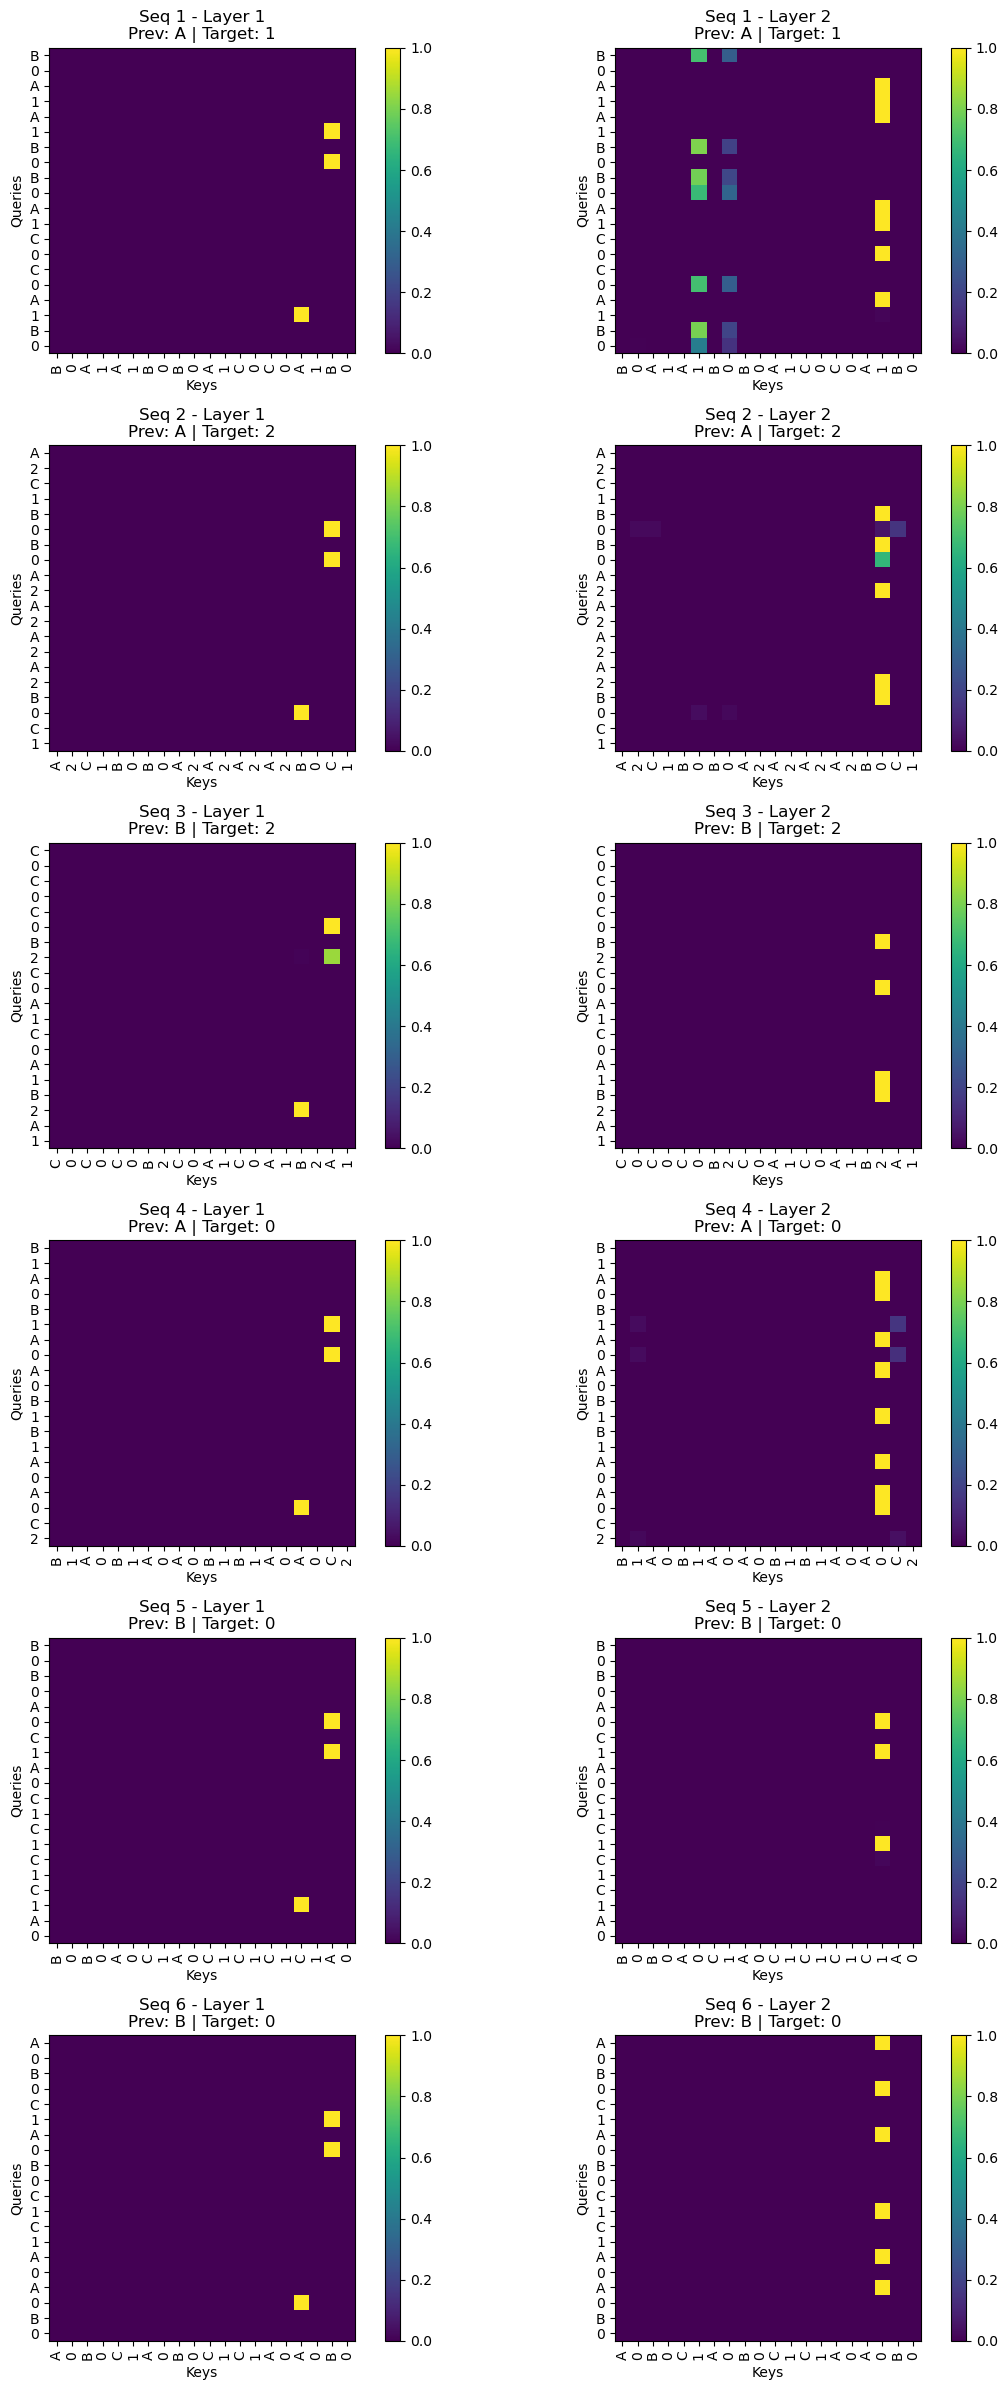

In [200]:
show_attention_matrices(model, test_loader, device, k=6, idx_to_token=idx_to_token)